Display data

In [1]:
import os
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

for row, partition in enumerate(['train', 'test', 'val']):
    i = 0
    for image in os.listdir(os.path.join('aug_data', partition, 'images')):
        img = cv2.imread(os.path.join('aug_data', partition, 'images', image))
        json_path = os.path.join('aug_data', partition, 'labels', f"{'.'.join(image.split('.')[:2])}.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as json_file:
                label_data = json.load(json_file)  
            label_info = str(label_data)  
        else:
            label_info = "No JSON"
       
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        
        cv2.rectangle(img, 
                    tuple(np.multiply(label_data['bbox'][:2], [450,450]).astype(int)),
                    tuple(np.multiply(label_data['bbox'][2:], [450,450]).astype(int)), 
                            (255,0,0), 2)

        ax[row, i].imshow(img)
        ax[row, i].set_title(f"{partition} - {image}", fontsize=8)
        
        i += 1
        if i == 4: break 

plt.tight_layout()
plt.show()

Prepare Datasets merging images with their labels

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    class_label = tf.cast(label["class"], tf.uint8)  
    coords_label = tf.cast(label["bbox"], tf.float16)  

    return class_label, coords_label

In [7]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels = train_labels.map( lambda x,y: (tf.ensure_shape(x, ()), tf.ensure_shape(y, (4,))) )
print(train_labels.as_numpy_iterator().next())
print(train_labels)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

(1, array([0.1865, 0.    , 0.7764, 0.8496], dtype=float16))
<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float16, name=None))>


In [ ]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    sample_image = sample_image.copy()  

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)


Prepare Model

In [ ]:
from tensorflow.keras.applications import VGG16

vgg = VGG16(include_top=False, input_shape=(120, 120, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input

input_layer = Input(shape=(120, 120, 3))

vgg = VGG16(include_top=False, weights=None, input_tensor=input_layer)

f1 = layers.GlobalMaxPooling2D()(vgg.output)
class1 = layers.Dense(2048, activation='relu')(f1)
class2 = layers.Dense(1, activation='sigmoid', name='face_output')(class1)

f2 = layers.GlobalMaxPooling2D()(vgg.output)
regress1 = layers.Dense(2048, activation='relu')(f2)
regress2 = layers.Dense(4, activation='sigmoid', name='box_output')(regress1)

facetracker = models.Model(inputs=input_layer, outputs=[class2, regress2])

facetracker.compile(
    optimizer='adam',
    loss={
        'face_output': 'binary_crossentropy',
        'box_output': 'mse',
    },
    metrics={
        'face_output': 'accuracy',
        'box_output': 'mse',
    }
)

facetracker.summary()


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 120, 120, 64)         1792      ['input_13[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 120, 120, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)           0         ['block1_conv2[0][0]']        
                                                                                           

In [ ]:
history = facetracker.fit(
    train, 
    epochs=5,
)

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image = sample_image.copy()

    if yhat[0][idx] > 0.85:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

for i in range(1, 6): 
    byte_img = tf.io.read_file(f'test{i}.jpg')
    img = tf.io.decode_jpeg(byte_img)
    img_resized = tf.image.resize(img, (120, 120))  
    img_normalized = img_resized / 255.0  

    yhat = model.predict(np.expand_dims(img_normalized, 0))
    sample_coords = yhat[1][0]

    img_np = img.numpy()  
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  

    if yhat[0][0] > 0.5: 
        start_point = np.multiply(sample_coords[:2], [img.shape[1], img.shape[0]]).astype(int)
        end_point = np.multiply(sample_coords[2:], [img.shape[1], img.shape[0]]).astype(int)
        cv2.rectangle(img_np, tuple(start_point), tuple(end_point), (255, 0, 0), 2)

        label_start = tuple(np.add(start_point, [0, -30]))
        label_end = tuple(np.add(start_point, [80, 0]))
        cv2.rectangle(img_np, label_start, label_end, (255, 0, 0), -1)

        cv2.putText(img_np, 'Face', tuple(np.add(start_point, [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))  
    plt.axis('off')
    plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def load_and_preprocess_image(image_path, target_size=(120, 120)):
    try:
        byte_img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(byte_img)
        img_resized = tf.image.resize(img, target_size)
        img_normalized = img_resized / 255.0
        return tf.expand_dims(img_normalized, axis=0) 
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

def visualize_activations(layer_name, activation, max_filters=6):
    num_filters = activation.shape[-1]
    size = activation.shape[1]
    display_filters = min(max_filters, num_filters)

    fig, axes = plt.subplots(1, display_filters, figsize=(20, 5))
    for i in range(display_filters):
        ax = axes[i]
        ax.matshow(activation[0, :, :, i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Filtro {i+1}")
    plt.suptitle(f'Activaciones - {layer_name}', fontsize=16)
    plt.show()

import numpy as np

def get_top_filters(activation, num_top_filters=5):
    """
    Obtiene los índices de los filtros con mayor activación promedio.
    """
    filter_means = np.mean(activation, axis=(0, 1, 2))  
    top_filters = np.argsort(filter_means)[-num_top_filters:]  
    return top_filters, filter_means

layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

test_image = load_and_preprocess_image('test1.jpg')

for layer_name, activation in zip(layer_names, activations):
    top_filters, filter_means = get_top_filters(activation)
    print(f"Capa: {layer_name}")
    print(f"Índices de los filtros más importantes: {top_filters}")
    print(f"Activaciones promedio: {[filter_means[i] for i in top_filters]}")

    visualize_activations(layer_name, activation[:, :, :, top_filters])



if test_image is not None:
    activations = activation_model.predict(test_image)
    
    for layer_name, activation in zip(layer_names, activations):
        print(f"Visualizando activaciones de la capa: {layer_name}")
        visualize_activations(layer_name, activation)
else:
    print("No se pudo cargar la imagen de prueba.")


In [ ]:
def load_and_preprocess_image(image_path, target_size=(120, 120)):
    try:
        byte_img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(byte_img)
        img_resized = tf.image.resize(img, target_size)
        img_normalized = img_resized / 255.0
        return tf.expand_dims(img_normalized, axis=0)  
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None
test_image = load_and_preprocess_image('test1.jpg')

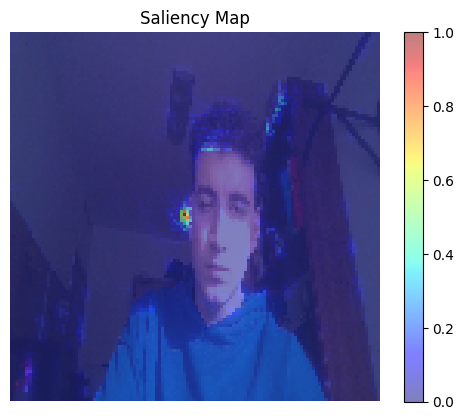

In [ ]:

def compute_saliency_map(model, img, output_index=0):
    """
    Calcula un mapa de saliencia basado en gradientes.
    """
    img_tensor = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)[output_index]
        loss = predictions[:, 0]  

    grads = tape.gradient(loss, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()[0]
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency)) 
    return saliency

saliency_map = compute_saliency_map(model, test_image)

plt.imshow(tf.squeeze(test_image), cmap='viridis', alpha=0.8)
plt.imshow(saliency_map, cmap='jet', alpha=0.5)  
plt.title("Saliency Map")
plt.axis('off')
plt.colorbar()
plt.show()


Capa: conv2d_18
Índices de los filtros más importantes: [24 28 12 23 20]
Activaciones promedio: [0.023561077, 0.030597834, 0.08199184, 0.10671313, 0.26646492]


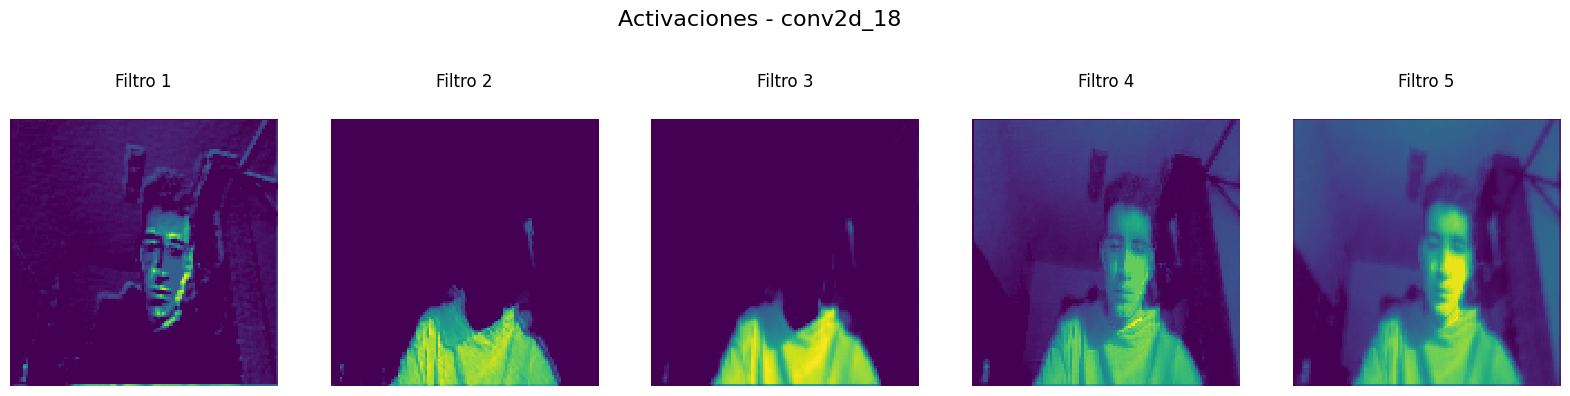

Capa: conv2d_19
Índices de los filtros más importantes: [38 12 29 50 33]
Activaciones promedio: [0.03056805, 0.041784197, 0.07070691, 0.07824949, 0.13453229]


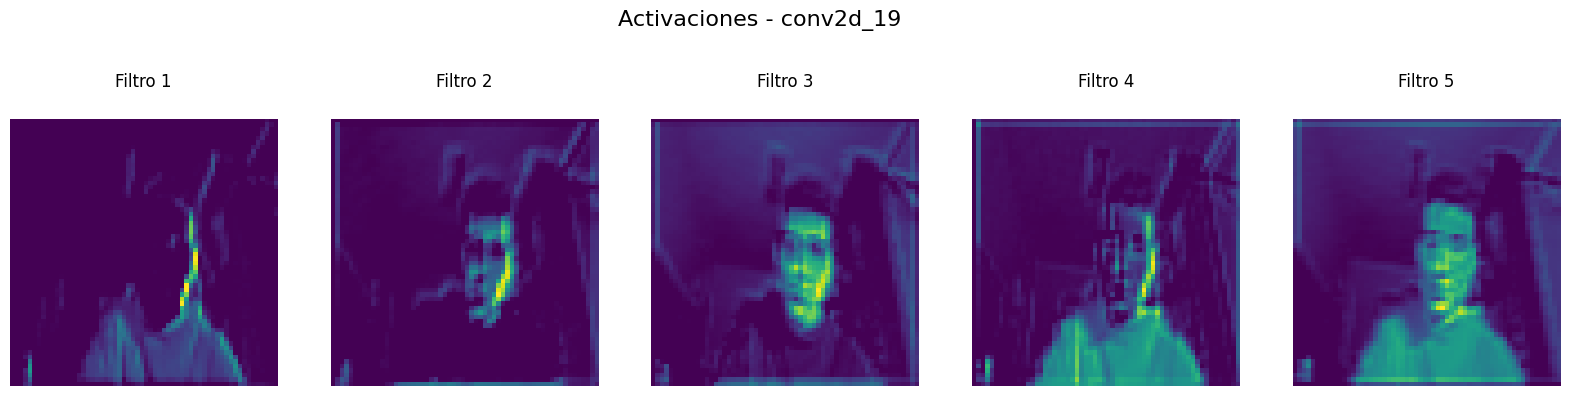

Capa: conv2d_20
Índices de los filtros más importantes: [  1  22  61 120 125]
Activaciones promedio: [0.026418427, 0.027325906, 0.032348808, 0.037002973, 0.049157992]


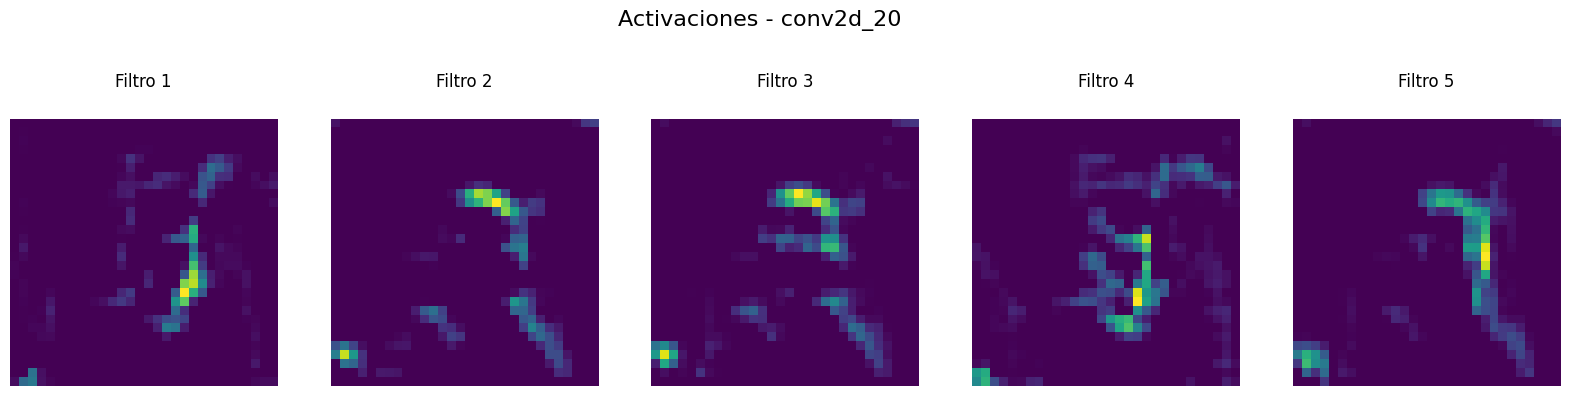

In [ ]:
import numpy as np

def get_top_filters(activation, num_top_filters=5):
    """
    Obtiene los índices de los filtros con mayor activación promedio.
    """
    filter_means = np.mean(activation, axis=(0, 1, 2))  
    top_filters = np.argsort(filter_means)[-num_top_filters:]  
    return top_filters, filter_means

layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

for layer_name, activation in zip(layer_names, activations):
    top_filters, filter_means = get_top_filters(activation)
    print(f"Capa: {layer_name}")
    print(f"Índices de los filtros más importantes: {top_filters}")
    print(f"Activaciones promedio: {[filter_means[i] for i in top_filters]}")

    visualize_activations(layer_name, activation[:, :, :, top_filters])


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

byte_img = tf.io.read_file('test6.jpg')
img = tf.io.decode_jpeg(byte_img)
img_resized = tf.image.resize(img, (120, 120))  
img_normalized = img_resized / 255.0  

yhat = model.predict(np.expand_dims(img_normalized, 0))
sample_coords = yhat[1][0]

img_np = img.numpy()  
img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)  

if yhat[0][0] > 0.5:  
    start_point = np.multiply(sample_coords[:2], [img.shape[1], img.shape[0]]).astype(int)
    end_point = np.multiply(sample_coords[2:], [img.shape[1], img.shape[0]]).astype(int)
    cv2.rectangle(img_np, tuple(start_point), tuple(end_point), (255, 0, 0), 2)

    label_start = tuple(np.add(start_point, [0, -30]))
    label_end = tuple(np.add(start_point, [80, 0]))
    cv2.rectangle(img_np, label_start, label_end, (255, 0, 0), -1)

    cv2.putText(img_np, 'Face', tuple(np.add(start_point, [0, -5])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

# Mostrar la imagen con Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))  
plt.axis('off')
plt.show()


In [ ]:
model.save('facetrackerv4.h5')

e:\IA\face_detection\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [78]:
from tensorflow.keras.models import load_model
facetrackerv2 = load_model("facetrackerv2.h5")

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetrackerv2.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image = sample_image.copy()

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model
facetrackerv2 = load_model("facetrackerv2.h5")

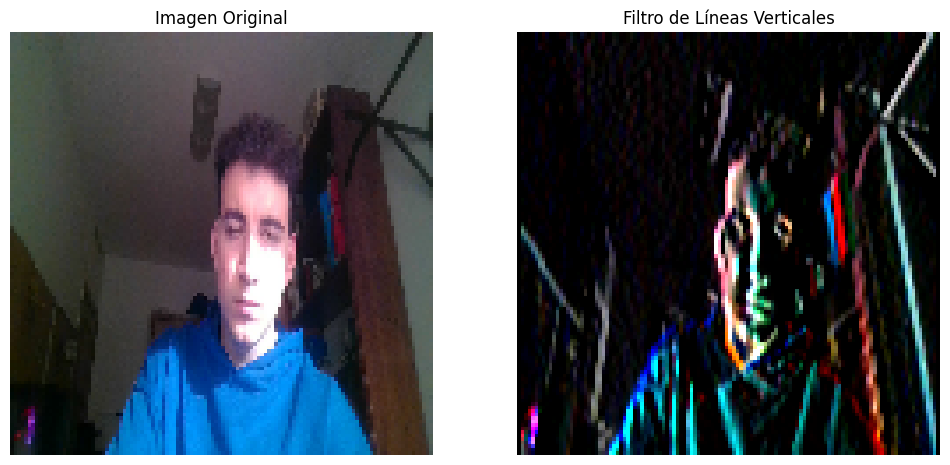

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

byte_img = tf.io.read_file('test1.jpg')
img = tf.io.decode_jpeg(byte_img)
img_resized = tf.image.resize(img, (120, 120))  
img_np = img_resized.numpy().astype(np.uint8)  

vertical_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

filtered_img = cv2.filter2D(img_np, -1, vertical_kernel)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Filtro de Líneas Verticales")
plt.imshow(filtered_img)
plt.axis('off')

plt.show()


In [ ]:
from tensorflow.keras.models import load_model
facetrackerv2 = load_model("facetrackerv2.h5")

In [ ]:

cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetrackerv2.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.9: 
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,255,0), 2)
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (0,255,0), -1)
        
        cv2.putText(frame, 'facetrackerv2', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    yhat2 = facetrackerv2.predict(np.expand_dims(resized/255,0))
    sample_coords2 = yhat2[1][0]

    if yhat2[0] > 0.9: 
        cv2.rectangle(frame, 
                    tuple(np.multiply(sample_coords2[:2], [450,450]).astype(int)),
                    tuple(np.multiply(sample_coords2[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        cv2.rectangle(frame, 
                    tuple(np.add(np.multiply(sample_coords2[:2], [450,450]).astype(int), 
                                    [0,-30])),
                    tuple(np.add(np.multiply(sample_coords2[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        cv2.putText(frame, 'model', tuple(np.add(np.multiply(sample_coords2[:2], [450,450]).astype(int),
                                            [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()